In [1]:
import sys
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import time

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
import QES.general_python.common.binary as Binary
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import JAX_AVAILABLE, get_backend, get_global_logger
from QES.general_python.common.plot import Plotter, MatrixPrinter

# ------------------------------------------------------------------
#! Lattice
from QES.general_python.lattices import choose_lattice, plot_bonds

# ------------------------------------------------------------------
#! Sampler
import QES.Solver.MonteCarlo.sampler as Sampler
import QES.NQS.nqs as NQS
import QES.NQS.nqs_train as NQST
import QES.NQS.tdvp as TDVP
from QES.general_python.ml.schedulers import EarlyStopping, ConstantScheduler, ExponentialDecayScheduler

# ------------------------------------------------------------------
#! ODE solver
from QES.general_python.algebra.ode import choose_ode

# ------------------------------------------------------------------
#! Networks
from QES.general_python.ml.net_impl.networks.net_rbm import RBM
from QES.general_python.ml.net_impl.networks.net_cnn import CNN
from QES.general_python.ml.net_impl.activation_functions import relu_jnp, tanh_jnp, sigmoid_jnp, leaky_relu_jnp, elu_jnp, poly6_jnp, softplus_jnp

# ------------------------------------------------------------------
#! Hamiltonians
from QES.general_python.algebra.linalg import act, overlap
from QES.Algebra.Model.dummy import DummyHamiltonian
from QES.Algebra.Model.Interacting.Spin.heisenberg_kitaev import HeisenbergKitaev
from QES.Algebra.Model.Interacting.Spin.transverse_ising import TransverseFieldIsing

# ------------------------------------------------------------------
#! Linear algebra
import QES.general_python.algebra.solvers.stochastic_rcnfg as SR
import QES.general_python.algebra.solvers as solvers
import QES.general_python.algebra.preconditioners as preconditioners

# ------------------------------------------------------------------

#! Spin operators
import QES.Algebra.Operator.operators_spin as op_spin
#! Fermionic operators
import QES.Algebra.Operator.operators_spinless_fermions as op_sferm

#! Backends
if JAX_AVAILABLE:
    import jax
    import jax.numpy as jnp
else:
    jax = None
    jnp = None
    
# ------------------------------------------------------------------
# lattice_type        = 'honeycomb'
lattice_type        = 'square'
lx, ly, lz          = 12, 1, 1
# lx, ly, lz          = 10, 1, 1
# ------------------------------------------------------------------
scheduler           = 'ExponentialDecay'
ode_solver_type     = 'Euler'
# ode_solver_type   = 'Heun'
# ode_solver_type   = 'AdaptiveHeun'
# ode_solver_type   = 'RK4'
lr                  = 0.1 # is also dt
# ------------------------------------------------------------------
network_type        = 'RBM'
# network_type        = 'CNN'
alpha               = 2
# ------------------------------------------------------------------
# ham_type            = 'HeisenbergKitaev'
ham_type            = 'TransverseFieldIsing'
# ham_type            = 'DummyHamiltonian'
ham_dtype           = jnp.float32
# ------------------------------------------------------------------

logger              = get_global_logger()
backend             = 'jax'
seed                = 0
dtypex              = jnp.complex128
be_modules          = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

# ------------------------------------------------------------------


19_05_2025_00-04_27 [INFO] Log file created: ./log/QES_19_05_2025_00-04_27.log
19_05_2025_00-04_27 [INFO] Log level set to: info
19_05_2025_00-04_27 [INFO] ############Global logger initialized.############
19_05_2025_00-04_27 [INFO] JAX backend available and successfully imported
19_05_2025_00-04_27 [INFO] 	JAX 64-bit precision enabled.
19_05_2025_00-04_28 [INFO] Setting JAX as the active backend.
19_05_2025_00-04_28 [INFO] **************************************************
19_05_2025_00-04_28 [INFO] Backend Configuration:
19_05_2025_00-04_28 [INFO] 		NumPy Version: 2.1.3
19_05_2025_00-04_28 [INFO] 		SciPy Version: 1.15.2
19_05_2025_00-04_28 [INFO] 		JAX Version: 0.5.3
19_05_2025_00-04_28 [INFO] 		Active Backend: jax
19_05_2025_00-04_28 [INFO] 			JAX Available: True
19_05_2025_00-04_28 [INFO] 			Default Seed: 42
19_05_2025_00-04_28 [INFO] 		JAX Backend Details:
19_05_2025_00-04_28 [INFO] 				Main Module: jax.numpy
19_05_2025_00-04_28 [INFO] 				Random Module: jax.random (+ PRNGKey)
19

### Lattice interface

In [2]:
lattice = choose_lattice(
    typek = lattice_type,
    lx    = lx,
    ly    = ly,
    lz    = lz,
    bc    = 'mbc'
)
ns, mult, st_shape = lattice.ns, lattice.ns // (lx * ly * lz), (lattice.ns, )
lattice.print_forward(logger=logger)

# lattice
# MatrixPrinter.print_matrix(A)

19_05_2025_00-04_28 [INFO] 	->Neighbors of site 0: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 0: 1
19_05_2025_00-04_28 [INFO] 	->Neighbors of site 1: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 1: 2
19_05_2025_00-04_28 [INFO] 	->Neighbors of site 2: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 2: 3
19_05_2025_00-04_28 [INFO] 	->Neighbors of site 3: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 3: 4
19_05_2025_00-04_28 [INFO] 	->Neighbors of site 4: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 4: 5
19_05_2025_00-04_28 [INFO] 	->Neighbors of site 5: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 5: 6
19_05_2025_00-04_28 [INFO] 	->Neighbors of site 6: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 6: 7
19_05_2025_00-04_28 [INFO] 	->Neighbors of site 7: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 7: 8
19_05_2025_00-04_28 [INFO] 	->Neighbors of site 8: 1
19_05_2025_00-04_28 [INFO] 		->Neighbor 0 of site 8: 9
19_05_2025_00-04_28 [INFO] 	

### Operators to test later on

In [3]:
sig_z = op_spin.sig_z(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)

sig_x = op_spin.sig_x(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)

sig_z_c = op_spin.sig_z(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)

sig_x_c = op_spin.sig_x(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)

if lattice.ns == 2:
    matrix_test = np.kron(op_spin._SIG_X, op_spin._SIG_0) * (0.5)
    print('Matrix test:', matrix_test)

### Hamiltonian - Hamiltonian operator $H$ and its expectation value $\langle H \rangle$.

In [4]:
if ham_type == 'HeisenbergKitaev':
    hamil = HeisenbergKitaev(lattice    = lattice,
                        hilbert_space   = None,
                        hx              = 0.0,
                        hz              = 0.0,
                        kx              = 1.0,
                        ky              = 1.0,
                        kz              = 1.0,
                        j               = 0.0,
                        dlt             = 1.0,
                        dtype           = ham_dtype,
                        use_forward     = False,
                        backend         = backend)

elif ham_type == 'TransverseFieldIsing':
    hamil = TransverseFieldIsing(
                        lattice        = lattice,
                        hilbert_space  = None,
                        hz             = 2.5,
                        hx             = -1.4,
                        # hx             = -0.7,    # same, but we use spin = 1/2
                        j              = 4.0,          
                        # j              = -1.0,    # same, but we use spin = 1/2          
                        dtype          = ham_dtype,
                        backend        = backend
                )
elif ham_type == 'DummyHamiltonian':
    hamil = DummyHamiltonian(
                        lattice        = lattice,
                        hilbert_space  = None,
                        dtype          = ham_dtype,
                        backend        = backend
                )
else:
    raise ValueError(f"Unknown Hamiltonian type: {ham_type}")

logger.title('Hamiltonian', desired_size=150, fill='#', color='red')
hamil

19_05_2025_00-04_28 [INFO] 	->[Transverse Field Ising Model] Building TFIM operator list...
19_05_2025_00-04_28 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier 1.399999976158142
19_05_2025_00-04_28 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 1 (sites: [1]) with multiplier 1.399999976158142
19_05_2025_00-04_28 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 2 (sites: [2]) with multiplier 1.399999976158142
19_05_2025_00-04_28 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 3 (sites: [3]) with multiplier 1.399999976158142
19_05_2025_00-04_28 [INFO] 		->[Transverse Field Ising Model] Adding modifying operator Operator

TFIM(Ns=12, J=4.0, hx=-1.4)

In [5]:
if hamil.hilbert_size <= 2**20:
    time0   = time.time()
    hamil.build(use_numpy=True)
    time1   = time.time()
    logger.info(f"Time to build Hamiltonian: {time1 - time0:.2f} seconds", color='green')
    
    if hamil.hilbert_size <= 2**12:
        hamil.diagonalize()
    else:
        hamil.diagonalize(method = 'lanczos', k = 50)
    time2   = time.time()
    logger.info(f"Time to diagonalize Hamiltonian: {time2 - time1:.2f} seconds", color='blue')
    eigv    = hamil.get_eigval()
    
    #! Test the operator expectation in the ground state
    if hamil.hilbert_size <= 2**12:
        gs              = hamil.get_eigvec(0)
        # test energy 
        hamil_mat       = hamil.hamil
        energy_0        = overlap(gs, hamil_mat, backend = np)   
        logger.info(f"Energy of the ground state: {energy_0:.4f}", color='green')
        
        sig_x_op_mat    = sig_x.matrix(dim = hamil.hilbert_size, use_numpy = True)
        sig_z_op_mat    = sig_z.matrix(dim = hamil.hilbert_size, use_numpy = True)
        sig_x_op_mat_c  = sig_x_c.matrix(dim = hamil.hilbert_size, use_numpy = True)
        sig_z_op_mat_c  = sig_z_c.matrix(dim = hamil.hilbert_size, use_numpy = True)

        ed_sig_x_exp    = overlap(gs, sig_x_op_mat, backend = np)
        ed_sig_z_exp    = overlap(gs, sig_z_op_mat, backend = np)
        ed_sig_x_exp_c  = overlap(gs, sig_x_op_mat_c, backend = np)
        ed_sig_z_exp_c  = overlap(gs, sig_z_op_mat_c, backend = np)
        logger.info(f"sig_x expectation value: {ed_sig_x_exp:.4f}", color='green')
        logger.info(f"sig_z expectation value: {ed_sig_z_exp:.4f}", color='green')
        logger.info(f"sig_x expectation value (c): {ed_sig_x_exp_c:.4f}", color='green')
        logger.info(f"sig_z expectation value (c): {ed_sig_z_exp_c:.4f}", color='green')
    else:
        ed_sig_x_exp    = None
        ed_sig_z_exp    = None
        ed_sig_x_exp_c  = None
        ed_sig_z_exp_c  = None
        logger.info(f"(TODO) Cannot compute expectation values for Hamiltonian: {hamil.hilbert_size} > 2^12", color='red')
else:
    eigv                = [None]
    ed_sig_x_exp        = None
    ed_sig_z_exp        = None
    ed_sig_x_exp_c      = None
    ed_sig_z_exp_c      = None
    logger.info(f"Cannot diagonalize Hamiltonian: {hamil.hilbert_size} > 2^20", color='red')
    

19_05_2025_00-04_28 [INFO] 			->[Transverse Field Ising Model] JAX is available but NumPy is forced...
19_05_2025_00-04_28 [INFO] 		->[Transverse Field Ising Model] Calculating the Hamiltonian matrix using NumPy...
19_05_2025_00-04_30 [INFO] Time to build Hamiltonian: 1.56 seconds
19_05_2025_00-04_38 [INFO] Time to diagonalize Hamiltonian: 7.69 seconds
19_05_2025_00-04_38 [INFO] Energy of the ground state: -27.9033
19_05_2025_00-04_38 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_00-04_38 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_00-04_38 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_00-04_38 [INFO] 		->[HilbertSpace] Inferred Ns=12 from Nh=4096 and Nhl=2
19_05_2025_00-04_38 [INFO] sig_x expectation value: -0.1074
19_05_2025_00-04_38 [INFO] sig_z expectation value: 0.4883
19_05_2025_00-04_38 [INFO] sig_x expectation value (c): 0.0139
19_05_2025_00-04_38 [INFO] sig_z expectation value (c): 0.2386


#### Plot if needed

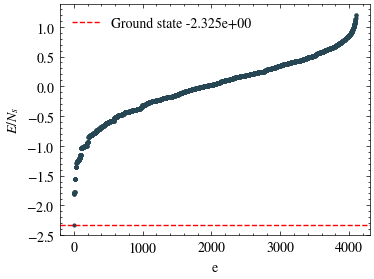

In [6]:
if eigv is not None and len(eigv) > 1:
    fig, ax = Plotter.get_subplots(
        nrows       = 1,
        ncols       = 1,
        figsize     = (4, 3),
        dpi         = 100,
    )
    x   = np.arange(0, len(eigv))
    y   = eigv
    ax[0].plot(x, y / lattice.ns, 'o', markersize=2)
    ax[0].set_xlabel(r'$\mathcal{e}$')
    ax[0].set_ylabel(r'$E/N_s$')
    ax[0].axhline(eigv[0] / lattice.ns, color='r', linestyle='--', label=f'Ground state {eigv[0] / lattice.ns :.3e}')
    ax[0].legend()

### Network - variational ansatz body $\psi _\theta (s)$ and its gradient $\nabla \psi _\theta (s)$.

In [7]:
if network_type == 'RBM':
    net = RBM(
        input_shape         = st_shape, 
        n_hidden            = int(alpha * ns),
        dtype               = dtypex,
        param_dtype         = dtypex,
        seed                = seed,
        visible_bias        = True,
        bias                = True,
    )
elif network_type == 'CNN':
    net     = CNN(
        input_shape         = st_shape,
        reshape_dims        = (lx, ly * mult),
        features            = (8,) * alpha,
        strides             = [(1, 1)] * alpha,
        kernel_sizes        = [(2, 2)] * alpha,
        activations         = [elu_jnp] * alpha,
        dtype               = dtypex,
        param_dtype         = dtypex,
        final_activation    = elu_jnp,
        seed                = seed,
        output_shape        = (1,)
    )
else:
    raise ValueError(f"Unknown network type: {network_type}")
net

19_05_2025_00-04_40 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
19_05_2025_00-04_40 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=324, is_holomorphic=True


ComplexRBM(shape=(12,), hidden=24, bias=on, visible_bias=on, dtype=complex128, params=324, analytic_grad=False, initialized)

### Sampler - sampling from the distribution $p_\theta (s)$.

In [8]:
n_chains        = 5
n_samples       = 200
n_therm_steps   = 25
sampler         = Sampler.MCSampler(
                    net             = net,
                    shape           = st_shape,
                    rng             = rng,
                    rng_k           = rng_k,
                    numchains       = n_chains,
                    numsamples      = n_samples,
                    sweep_steps     = min(ns, 28),
                    backend         = backend_np,
                    therm_steps     = n_therm_steps,
                    mu              = 2.0,
                    seed            = seed,
                    dtype           = dtypex,
                    statetype       = np.float64,
                    makediffer      = True
                )
do_tests    = False
sampler_fun = sampler.get_sampler_jax()
sampler

MCSampler(shape=(12,), mu=2.0, beta=1.0, therm_steps=25, sweep_steps=12, numsamples=200, numchains=5, backend=jax)

### Stepper - TDVP stepper for the time evolution of the state $\psi _\theta (s)$.

In [9]:
ode_solver = choose_ode(ode_type = ode_solver_type, backend = backend_np, dt = lr, rhs_prefactor = -1.0)
ode_solver

Euler(dt=0.1, backend=jax, rhs_p=-1.0)

### NQS - neural network quantum state $\psi_\theta (s)$ and its gradient $\nabla \psi_\theta (s)$.

In [10]:
n_epo           = 500
n_sweep_steps   = ns
n_batch         = 128

# Other
reg             = 1e-2
maxiter         = 600
tolerance       = 1e-8
use_min_sr      = False

# Solver
solver_id       = solvers.SolverType.SCIPY_CG
precond_id      = preconditioners.PreconditionersTypeSym.JACOBI
precond         = preconditioners.choose_precond(precond_id=precond_id, backend=backend_np)
# precond_id      = None

tdvp = TDVP.TDVP(
    use_sr          = True,
    use_minsr       = False,
    rhs_prefactor   = 1.0,
    sr_lin_solver   = solver_id,
    sr_precond      = precond,
    sr_pinv_tol     = tolerance,
    sr_pinv_cutoff  = 1e-8,
    sr_snr_tol      = tolerance,
    sr_diag_shift   = reg,
    sr_lin_solver_t = solvers.SolverForm.GRAM,
    sr_maxiter      = maxiter,
    backend         = backend_np
)
tdvp

19_05_2025_00-04_40 [INFO] 	->[Jacobi Preconditioner] Resetting backend to: <module 'jax.numpy' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/numpy/__init__.py'>
19_05_2025_00-04_40 [INFO] 		->[Jacobi Preconditioner] JIT compiling apply_gram(r, S, Sp, ...) function...


TDVP(backend=jax,use_sr=True,use_minsr=False,rhs_prefactor=1.0,sr_snr_tol=1e-08,sr_pinv_tol=1e-08,sr_diag_shift=0.01,sr_maxiter=600)

In [11]:
nqs = NQS.NQS(
            net             = net,
            sampler         = sampler,
            hamiltonian     = hamil,
            lower_betas     = None,
            lower_states    = None,
            seed            = seed,
            beta            = 1.0,
            mu              = sampler.get_mu(),
            shape           = st_shape,
            backend         = backend_np,
            batch_size      = n_batch,
            dtype           = dtypex,  
        )
nqs.reset()

nqs_train = NQST.NQSTrainer(
    nqs             = nqs,
    ode_solver      = ode_solver,
    tdvp            = tdvp,
    n_batch         = n_batch,
    lr_scheduler    = ExponentialDecayScheduler(lr, n_epo, lr_decay=3e-4, logger=logger, lr_clamp=3e-2),
    early_stopper   = EarlyStopping(patience = 500, min_delta=1e-4, logger=logger),
    reg_scheduler   = ConstantScheduler(reg, max_epochs=n_epo, lr_clamp=1e-2, logger=logger),
    logger          = logger,
)
nqs

19_05_2025_00-04_40 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
19_05_2025_00-04_40 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=324, is_holomorphic=True
19_05_2025_00-04_40 [INFO] 	->[GeneralNet] Network <class 'QES.general_python.ml.net_impl.networks.net_rbm.RBM'> initialized with forced init.
19_05_2025_00-04_40 [INFO] [ExponentialDecayScheduler] Initialized with initial LR: 1.0000e-01, decay rate: 0.0003
19_05_2025_00-04_40 [INFO] [ConstantScheduler] Initialized with constant LR: 1.0000e-02


NQS(ansatz=FlaxNetInterface(input_dim=12, dtype=complex128, flax_module=_FlaxRBM),sampler=MCSampler:
  - State shape: (12,) (Size: 12)
  - Backend: jax
  - Chains: 5, Samples/Chain: 200
  - Params: mu=2.000, beta=1.000, logprob_fact=0.500
  - Thermalization: 25 sweeps x 12 steps/sweep (43200 total site updates/chain)
  - Sampling: 12 steps/sample (28800 total site updates/chain)
,backend=jax)

In [12]:
nqs_train

NQSTrainer(nqs=NQS(ansatz=FlaxNetInterface(input_dim=12, dtype=complex128, flax_module=_FlaxRBM),sampler=MCSampler:
  - State shape: (12,) (Size: 12)
  - Backend: jax
  - Chains: 5, Samples/Chain: 200
  - Params: mu=2.000, beta=1.000, logprob_fact=0.500
  - Thermalization: 25 sweeps x 12 steps/sweep (43200 total site updates/chain)
  - Sampling: 12 steps/sample (28800 total site updates/chain)
,backend=jax), ode_solver=Euler(dt=0.1, backend=jax, rhs_p=-1.0), tdvp=TDVP(backend=jax,use_sr=True,use_minsr=False,rhs_prefactor=1.0,sr_snr_tol=1e-08,sr_pinv_tol=1e-08,sr_diag_shift=0.01,sr_maxiter=600)

### Test the training of the NQS with a simple Hamiltonian.

In [13]:
nqs_train._reset_history()
history, history_std, timings = nqs_train.train(n_epochs=50, 
                        reset=False, use_lr_scheduler=(ode_solver_type=='Euler'), use_reg_scheduler=False)

19_05_2025_00-04_42 [INFO] 	->[EarlyStopping] EarlyStopping reset.


Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s, E/N=-2.3106e+00-3.1225e-05j ± 2.1333e-02, lr=9.9e-02, sig=1.0e-02, t_sample=4.80e-02s, t_step=6.89e-02s, t_update=4.87e-04s, t_gradient=2.87e-04s, t_prepare=1.72e-02s, t_solve=5.08e-02s, t_total=1.86e-01s]


19_05_2025_00-04_49 [INFO] Time breakdown (s):
19_05_2025_00-04_49 [INFO] 	->- sampling: 2.53e+00 (35.9%)
19_05_2025_00-04_49 [INFO] 	->- compute : 4.31e+00 (61.1%)
19_05_2025_00-04_49 [INFO] 	->- update  : 2.09e-01 (3.0%)
19_05_2025_00-04_49 [INFO] 	->- prepare : 8.58e-01 (12.2%)
19_05_2025_00-04_49 [INFO] 	->- solve   : 3.00e+00 (42.5%)
19_05_2025_00-04_49 [INFO] 	->- gradient: 3.34e-02 (0.5%)
19_05_2025_00-04_49 [INFO] - total   : 7.06e+00
19_05_2025_00-04_50 [INFO] Saved figure to './data/nqs_train/TransverseFieldIsing/gs_train.png' and JSON to './data/nqs_train/TransverseFieldIsing/'.
19_05_2025_00-04_50 [INFO] 	->Saved parameters to ./data/nqs_train/TransverseFieldIsing/gs_train_info.json
19_05_2025_00-04_50 [WARNING] Failed to save parameters: Object of type complex128 is not JSON serializable
19_05_2025_00-04_50 [WARNING] Parameters are not saved.
19_05_2025_00-04_50 [WARNING] 	->You can save them manually using `nqs.get_params()`.


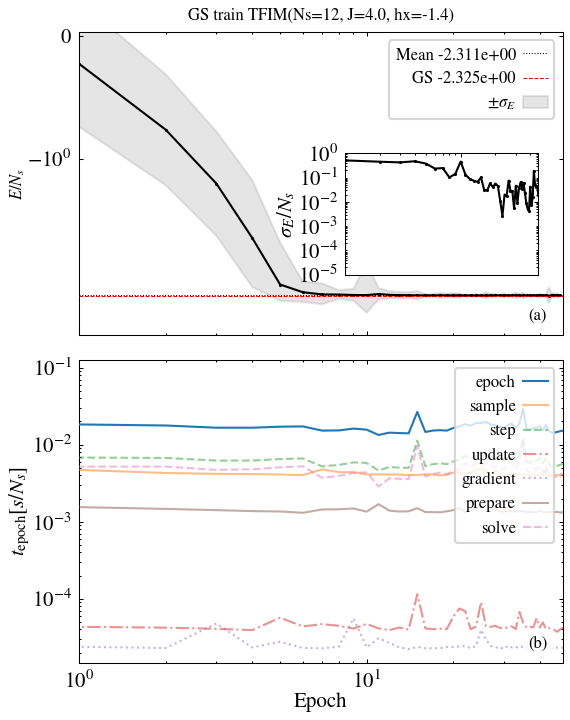

In [14]:
energy_plot = eigv[0] if eigv[0] is not None else -18.583590144097595
fig, ax = nqs_train.report_gs(eigv      =   energy_plot,
                            last_n      =   0.05,
                            savedir     =   f'./data/nqs_train/{ham_type}/',
                            plot_kwargs =   {
                                'ylim_0'        : (-3.5, 3e-2),
                                'ylim_1'        : (1e-5, 1e0),
                                'inset_axes'    : (0.55, 0.2, 0.4, 0.4),
                                'annotate_x'    : 0.93,
                                'annotate_y'    : 0.05
                            })

19_05_2025_00-00_55 [INFO] Operator(Sz/0, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.5000+0.0000j) ± (0.0000)  (N=1000)
19_05_2025_00-00_55 [INFO] 		->ref = 0.4883 - rel.err = 2.40 %
19_05_2025_00-00_55 [INFO] Operator(Sx/0, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.0019+0.0003j) ± (0.0006)  (N=1000)
19_05_2025_00-00_55 [INFO] 		->ref = -0.1074 - rel.err = 101.81 %
19_05_2025_00-00_55 [INFO] Operator(Sz/0-1, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.2450+0.0000j) ± (0.0497)  (N=1000)
19_05_2025_00-00_55 [INFO] 		->ref = 0.2386 - rel.err = 2.70 %
19_05_2025_00-00_55 [INFO] Operator(Sx/0-1, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (-0.0002-0.0000j) ± (0.0010)  (N=1000)
19_05_2025_00-00_55 [INFO] 		->ref = 0.0139 - rel.err = 101.48 %
19_05_2025_00-00_55 [INFO] Energy: E = (-2.7739e+01-4.4490e-03j) ± (0.2328) (N=1000)
None
None
None
None
19_05_2025_00-00_56 [INFO] sample: 1.15e-01 s
19_05_2025_00-00_56 [INFO] obs_0: 8.49e-02 s
19_05_2025_00-00_5

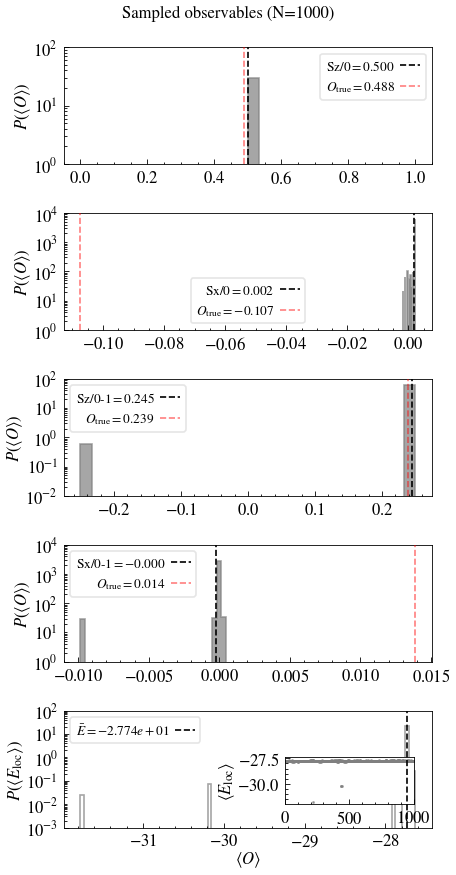

In [ ]:
results, energy, timings = nqs.eval_observables(
    operators      = [sig_z, sig_x, sig_z_c, sig_x_c],
    true_values    = [ed_sig_z_exp, ed_sig_x_exp, ed_sig_z_exp_c, ed_sig_x_exp_c],
    n_chains       = n_chains,
    n_samples      = n_samples,
    batch_size     = 100,
    logger         = logger,
    plot           = True,
    get_energy     = True,
    bins           = 200,
    true_en        = eigv[0],
    plot_kwargs    = {
        # 'xlim_0'    : (-0.5, 0.1),
        # 'xlim_1'    : (-0.5, 0.1),
        'inset_axes': (0.6, 0.2, 0.35, 0.4),
    }
)

### Test modifier

In [15]:
from QES.Algebra.Operator.operator import initial_states, create_operator

sites_all       = []
operators_inv   = []
# locals
sites           = [0]

operators_inv.append(
    create_operator(
        type_act        =   op_spin.OperatorTypeActing.Global,
        op_func_int     =   None,
        op_func_np      =   None,
        op_func_jnp     =   op_spin.sigma_z_inv_jnp,
        ns              =   lattice.ns,
        sites           =   sites,
        name            =   'sig_z_0',
        extra_args      =   (True, 1.0),
        modifies        =   False,
        
    )
)

operators_inv.append(
    create_operator(
        type_act        =   op_spin.OperatorTypeActing.Global,
        op_func_int     =   None,
        op_func_np      =   None,
        op_func_jnp     =   op_spin.sigma_x_inv_jnp,
        ns              =   lattice.ns,
        sites           =   sites,
        name            =   'sig_x_0',
        extra_args      =   (True, 1.0),
        modifies        =   False,
        
    )
)

# correlations
sites_corr = jnp.array([0, 3], dtype=jnp.int32)
def sig_z_c_modifier(x):
    return op_spin.sigma_z_inv_jnp(x, sites=sites_corr)

def sig_x_c_modifier(x):
    return op_spin.sigma_x_inv_jnp(x, sites=sites_corr)

# k-space
k       = 1.0
sites_k = jnp.arange(0, lattice.ns, dtype=jnp.int32)
def sig_k_modifier(x):
    return op_spin.sigma_k_inv_jnp(x, k=k, sites=sites_k)


names = ['sig_z', 'sig_x', 'sig_z_c', 'sig_x_c', 'sig_k']

sig_z_modifier_jit      = operators_inv[0].jax
sig_x_modifier_jit      = operators_inv[1].jax
sig_z_c_modifier_jit    = jax.jit(sig_z_c_modifier)
sig_x_c_modifier_jit    = jax.jit(sig_x_c_modifier)
sig_k_modifier_jit      = jax.jit(sig_k_modifier)

In [21]:
# test modifiers
_, _, st_jax = initial_states(lattice.ns, display=True)
st_jax       = (st_jax - 0.5) * 2

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
for modifier in [sig_z_modifier_jit, sig_x_modifier_jit]:
    st_out, st_val = modifier(st_jax)
    logger.title('Modifier', desired_size=150, fill='#', color='red')
    logger.info(f"Modified state: {st_out[0]}")
    logger.info(f"Original state: {st_jax}")
    logger.info(f"Modified state value: {st_val}")
    logger.info(f"Modified state shape: {st_out.shape}")

19_05_2025_00-05_07 [INFO] #######################################################################Modifier#######################################################################
19_05_2025_00-05_07 [INFO] Modified state: [-1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.]
19_05_2025_00-05_07 [INFO] Original state: [-1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.]
19_05_2025_00-05_07 [INFO] Modified state value: [-1.]
19_05_2025_00-05_07 [INFO] Modified state shape: (1, 12)
19_05_2025_00-05_07 [INFO] #######################################################################Modifier#######################################################################
19_05_2025_00-05_07 [INFO] Modified state: [ 1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.]
19_05_2025_00-05_07 [INFO] Original state: [-1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.]
19_05_2025_00-05_07 [INFO] Modified state value: [1.]
19_05_2025_00-05_07 [INFO] Modified state shape: (1, 12)


#### $\sigma_z$ - Pauli Z operator at site $i=0$.

In [23]:
(_, _), (cfgs, cfgs_psi), probs = nqs.sample()
cfgs

Array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float64)

In [24]:
nqs.unset_modifier()
two_states      = jnp.array([st_jax, st_jax], dtype=jnp.float32)
nqs_ansatz_old  = nqs.ansatz
nqs_eval_before = nqs_ansatz_old(nqs.get_params(), two_states)
print('Before:', nqs_eval_before)
print('Before exp:', jnp.exp(nqs_eval_before))
nqs.set_modifier(modifier=sig_z_modifier_jit, name=operators_inv[0].name)
nqs_ansatz_new  = nqs.ansatz
nqs_eval_new    = nqs_ansatz_new(nqs.get_params(), two_states)
print('After:', nqs_eval_new)
print('After exp:', jnp.exp(nqs_eval_new))

19_05_2025_00-05_11 [INFO] 		->[<class 'QES.NQS.nqs.NQS'>] State modifier unset.
Before: [6.72429147+11.60185633j 6.72429147+11.60185633j]
Before exp: [474.3046569-684.0284264j 474.3046569-684.0284264j]
19_05_2025_00-05_11 [INFO] 		->[<class 'QES.NQS.nqs.NQS'>] State modifier function set to <PjitFunction of <function make_jax_operator_closure.<locals>.compiled_op at 0x33a98de40>>.
After: [6.72429147+14.74344898j 6.72429147+14.74344898j]
After exp: [-474.3046569+684.0284264j -474.3046569+684.0284264j]


In [ ]:
out = nqs_ansatz_new(nqs.get_params(), cfgs)


#### Try to evaluate

19_05_2025_00-00_58 [INFO] Operator(Sx/0, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (-0.0019-0.0003j) ± (0.0007)  (N=1000)
19_05_2025_00-00_58 [INFO] 		->ref = 0.4883 - rel.err = 100.39 %
19_05_2025_00-00_58 [INFO] Energy: E = (-2.7743e+01+6.3536e-03j) ± (0.2715) (N=1000)
None
19_05_2025_00-00_59 [INFO] sample: 5.43e-02 s
19_05_2025_00-00_59 [INFO] obs_0: 1.05e-01 s
19_05_2025_00-00_59 [INFO] energy: 3.62e-01 s


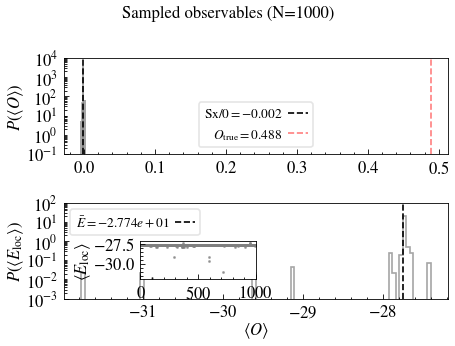

In [ ]:
results, energy, timings = nqs.eval_observables(
    operators      = [sig_x],
    true_values    = [ed_sig_z_exp],
    n_chains       = n_chains,
    n_samples      = n_samples,
    batch_size     = 100,
    logger         = logger,
    plot           = True,
    get_energy     = True,
    bins           = 200,
    true_en        = energy_0,
    plot_kwargs    = {
    }
)

#### ED evolution - exact diagonalization of the Hamiltonian $H$.

#### TDVP evolution - time-dependent variational principle (TDVP) evolution of the state $\psi_\theta (s)$.

In [ ]:
params_org      = nqs.get_params().copy()

In [47]:
dt              = 0.08
ode_solver_t    = choose_ode(ode_type = ode_solver_type, backend = backend_np, dt = dt, rhs_prefactor = 1.0)
ode_solver_t

Euler(dt=0.08, backend=jax, rhs_p=1.0)

In [48]:
# Other
reg             = 1e-2
maxiter         = 600
tolerance       = 1e-8
use_min_sr      = False

# Solver
solver_id       = solvers.SolverType.SCIPY_CG
precond_id      = preconditioners.PreconditionersTypeSym.JACOBI
precond         = preconditioners.choose_precond(precond_id=precond_id, backend=backend_np)
# precond_id      = None

tdvp_t = TDVP.TDVP(
    use_sr          = True,
    use_minsr       = False,
    rhs_prefactor   = -1.0j,
    sr_lin_solver   = solver_id,
    sr_precond      = precond,
    sr_pinv_tol     = tolerance,
    sr_pinv_cutoff  = 1e-8,
    sr_snr_tol      = tolerance,
    sr_diag_shift   = reg,
    sr_lin_solver_t = solvers.SolverForm.GRAM,
    sr_maxiter      = maxiter,
    backend         = backend_np
)
tdvp_t

19_05_2025_00-14_11 [INFO] 	->[Jacobi Preconditioner] Resetting backend to: <module 'jax.numpy' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/numpy/__init__.py'>
19_05_2025_00-14_11 [INFO] 		->[Jacobi Preconditioner] JIT compiling apply_gram(r, S, Sp, ...) function...


TDVP(backend=jax,use_sr=True,use_minsr=False,rhs_prefactor=(-0-1j),sr_snr_tol=1e-08,sr_pinv_tol=1e-08,sr_diag_shift=0.01,sr_maxiter=600)

In [49]:
# evolve
from contextlib import contextmanager

_nqs            = nqs
_nqs.set_params(params_org)
t_start         = 0.0
t_num           = 50
t_end           = t_start + dt * t_num
current_time    = t_start
timings         = {
    'sample'   : [],
    'step'     : [],
    'update'   : [],
    'evaluate' : [],
}
#! check operator evolution
op              = sig_z_c
mean_values     = []
std_values      = []

@contextmanager
def _time(phase, funct, *args, **kwargs):
    result, elapsed = timeit(funct, *args, **kwargs)
    timings[phase].append(elapsed)
    yield result

_single_step = _nqs.wrap_single_step_jax()

iterate = 0
while current_time < t_end:

    logger.info(f"Current time: {current_time:.4f}: {iterate}/{t_num}", color='green')

    #! sampling
    with _time("sample", _nqs.sample, reset=False) as sample_out:
        (_, _), (cfgs, cfgs_psi), probs = sample_out

    #! energy + gradient
    params = _nqs.get_params(unravel=True)
    with _time("step", ode_solver_t.step,
                f               = tdvp_t,
                y               = params,
                t               = current_time,
                est_fn          = _single_step,
                configs         = cfgs,
                configs_ansatze = cfgs_psi,
                probabilities   = probs) as step_out:
        dparams, _, (info, meta) = step_out

    #! update
    with _time("update", _nqs.set_params, dparams,
                shapes  = meta[0],
                sizes   = meta[1],
                iscpx   = meta[2]) as update_out:
        pass
    
    #! evaluate observables
    params = _nqs.get_params(unravel=False)
    with _time("evaluate", funct = _nqs.evaluate_fun_jax, 
                func           = op.jax,
                states         = cfgs,
                probabilities  = probs,
                logproba_in    = cfgs_psi,
                logproba_fun   = _nqs.ansatz,
                parameters     = params,
                batch_size     = 50,
                ) as evaluate_out:
        (vals, mean_op, sig_op) = evaluate_out
        mean_values.append(mean_op)
        std_values.append(sig_op)
        logger.info(f"Mean value: {mean_op:.4f} +/- {sig_op:.4f}", color='green', lvl = 2)

    #! update time
    current_time += ode_solver_t.dt(0, 0)
    iterate      += 1
    

19_05_2025_00-14_12 [INFO] Current time: 0.0000: 0/50
19_05_2025_00-14_13 [INFO] 		->Mean value: 0.3054+0.0064j +/- 0.0651
19_05_2025_00-14_13 [INFO] Current time: 0.0800: 1/50
19_05_2025_00-14_13 [INFO] 		->Mean value: 0.2287-0.0186j +/- 0.0518
19_05_2025_00-14_13 [INFO] Current time: 0.1600: 2/50
19_05_2025_00-14_14 [INFO] 		->Mean value: 0.2276-0.0245j +/- 0.0600
19_05_2025_00-14_14 [INFO] Current time: 0.2400: 3/50
19_05_2025_00-14_14 [INFO] 		->Mean value: 0.2340-0.0156j +/- 0.0506
19_05_2025_00-14_14 [INFO] Current time: 0.3200: 4/50
19_05_2025_00-14_15 [INFO] 		->Mean value: 0.2134-0.0009j +/- 0.0430
19_05_2025_00-14_15 [INFO] Current time: 0.4000: 5/50
19_05_2025_00-14_15 [INFO] 		->Mean value: 0.2222+0.0102j +/- 0.0696
19_05_2025_00-14_15 [INFO] Current time: 0.4800: 6/50
19_05_2025_00-14_15 [INFO] 		->Mean value: 0.2304+0.0333j +/- 0.0585
19_05_2025_00-14_15 [INFO] Current time: 0.5600: 7/50
19_05_2025_00-14_16 [INFO] 		->Mean value: 0.2249+0.0140j +/- 0.0628
19_05_2025_00-14

/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


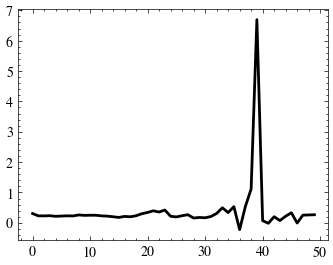

In [50]:
fig, ax = Plotter.get_subplots(
    nrows       = 1,
    ncols       = 1,
    figsize     = (4, 3),
    dpi         = 100,
)
Plotter.plot(
    ax      = ax[0],
    x       = np.arange(0, len(mean_values)),
    y       = np.array(mean_values),
)

19_05_2025_00-13_57 [INFO] Operator(Sz/0-1, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.2410+0.0000j) ± (0.0665)  (N=1000)
19_05_2025_00-13_57 [INFO] 		->ref = 0.2386 - rel.err = 1.02 %
19_05_2025_00-13_57 [INFO] Energy: E = (-2.6922e+01+4.5012e-02j) ± (2.4514) (N=1000)
None
19_05_2025_00-13_57 [INFO] sample: 6.70e-02 s
19_05_2025_00-13_57 [INFO] obs_0: 1.23e-03 s
19_05_2025_00-13_57 [INFO] energy: 1.86e-02 s


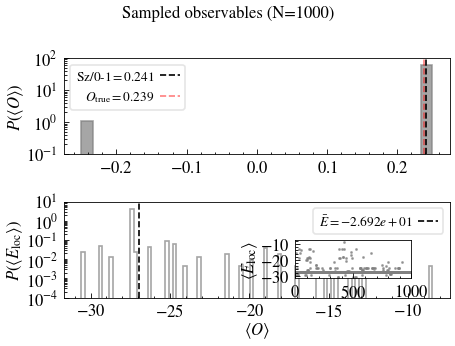

In [46]:
results, energy, timings = _nqs.eval_observables(
    operators      = [sig_z_c],
    true_values    = [ed_sig_z_exp_c],
    n_chains       = n_chains,
    n_samples      = n_samples,
    batch_size     = 100,
    logger         = logger,
    plot           = True,
    get_energy     = True,
    bins           = 200,
    true_en        = energy_0,
    plot_kwargs    = {
    }
)